In [1]:
import sys
import json
from pathlib import Path
import torch
import numpy as np
import meshplot as mp

root_dir = Path().resolve().parent
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

from joint.joint_prediction_set import JointPredictionSet
from joint.joint_environment import JointEnvironment
from datasets.joint_graph_dataset import JointGraphDataset
from train import JointPrediction

In [2]:
# Change to point to the Fusion 360 Gallery joint dataset
# this directory should contain the joint json and obj part files
data_dir = root_dir / "data/zw3d-joinable-dataset"

dataset = JointGraphDataset(
    root_dir=data_dir,
    split="train",
    center_and_scale=True,
    random_rotate=False,
    delete_cache=True,
    limit=0,
    threads=1,
    label_scheme="Joint",
    max_node_count=1024,
    input_features="axis_pos,axis_dir,bounding_box,entity_types,area,circumference,param_1,param_2,reversed,length,radius",
    skip_far=False,
    skip_interference=False,
    skip_nurbs=False,
    joint_type="all",
    without_synthetic=False,
    feature_embedding=False,
    num_bits=9
)

Data cache deleted from: /home/fusiqiao/Projects/JoinABLe/data/zw3d-joinable-dataset/train.pickle
Using official train test split
Loading 10373 train data


100%|██████████| 10373/10373 [08:06<00:00, 21.32it/s]


Total graph load time: 486.4481666088104 sec
Skipped: 1802 files
Done loading 8571 files
Data cache written to: /home/fusiqiao/Projects/JoinABLe/data/zw3d-joinable-dataset/train.pickle


In [3]:
from collections import defaultdict
from tqdm import tqdm

face_features = (
    "area",
    "circumference",
    "param_1",
    "param_2",
)

edge_features = (
    "length",
    "radius"
)

vector_features = (
    "axis_pos",
    "axis_dir"
)

def default_ndarray():
    return np.array([])
feature_to_values = defaultdict(default_ndarray)

for g1, g2, _ in tqdm(dataset):
    g1_face_indices = torch.where(g1["is_face"] > 0.5)[0].long()
    g2_face_indices = torch.where(g2["is_face"] > 0.5)[0].long()
    g1_edge_indices = torch.where(g1["is_face"] < 0.5)[0].long()
    g2_edge_indices = torch.where(g2["is_face"] < 0.5)[0].long()
    for feature in face_features:
        feature_to_values[feature] = np.append(feature_to_values[feature], g1[feature][g1_face_indices].numpy())
        feature_to_values[feature] = np.append(feature_to_values[feature], g2[feature][g2_face_indices].numpy())

    for feature in edge_features:
        feature_to_values[feature] = np.append(feature_to_values[feature], g1[feature][g1_edge_indices].numpy())
        feature_to_values[feature] = np.append(feature_to_values[feature], g2[feature][g2_edge_indices].numpy())
    
    for feature in vector_features:
        feature_to_values[feature + "_x"] = np.append(feature_to_values[feature + "_x"], g1[feature][:,0].numpy())
        feature_to_values[feature + "_y"] = np.append(feature_to_values[feature + "_y"], g1[feature][:,1].numpy())
        feature_to_values[feature + "_z"] = np.append(feature_to_values[feature + "_z"], g1[feature][:,2].numpy())
        feature_to_values[feature + "_x"] = np.append(feature_to_values[feature + "_x"], g2[feature][:,0].numpy())
        feature_to_values[feature + "_y"] = np.append(feature_to_values[feature + "_y"], g2[feature][:,1].numpy())
        feature_to_values[feature + "_z"] = np.append(feature_to_values[feature + "_z"], g2[feature][:,2].numpy())

    feature_to_values["bounding_box" + "_min_x"] = np.append(feature_to_values["bounding_box" + "_min_x"], g1["bounding_box"][:,0].numpy())
    feature_to_values["bounding_box" + "_min_y"] = np.append(feature_to_values["bounding_box" + "_min_y"], g1["bounding_box"][:,1].numpy())
    feature_to_values["bounding_box" + "_min_z"] = np.append(feature_to_values["bounding_box" + "_min_z"], g1["bounding_box"][:,2].numpy())
    feature_to_values["bounding_box" + "_max_x"] = np.append(feature_to_values["bounding_box" + "_max_x"], g1["bounding_box"][:,3].numpy())
    feature_to_values["bounding_box" + "_max_y"] = np.append(feature_to_values["bounding_box" + "_max_y"], g1["bounding_box"][:,4].numpy())
    feature_to_values["bounding_box" + "_max_z"] = np.append(feature_to_values["bounding_box" + "_max_z"], g1["bounding_box"][:,5].numpy())
    
    feature_to_values["bounding_box" + "_min_x"] = np.append(feature_to_values["bounding_box" + "_min_x"], g2["bounding_box"][:,0].numpy())
    feature_to_values["bounding_box" + "_min_y"] = np.append(feature_to_values["bounding_box" + "_min_y"], g2["bounding_box"][:,1].numpy())
    feature_to_values["bounding_box" + "_min_z"] = np.append(feature_to_values["bounding_box" + "_min_z"], g2["bounding_box"][:,2].numpy())
    feature_to_values["bounding_box" + "_max_x"] = np.append(feature_to_values["bounding_box" + "_max_x"], g2["bounding_box"][:,3].numpy())
    feature_to_values["bounding_box" + "_max_y"] = np.append(feature_to_values["bounding_box" + "_max_y"], g2["bounding_box"][:,4].numpy())
    feature_to_values["bounding_box" + "_max_z"] = np.append(feature_to_values["bounding_box" + "_max_z"], g2["bounding_box"][:,5].numpy())

100%|██████████| 8571/8571 [02:55<00:00, 48.81it/s] 


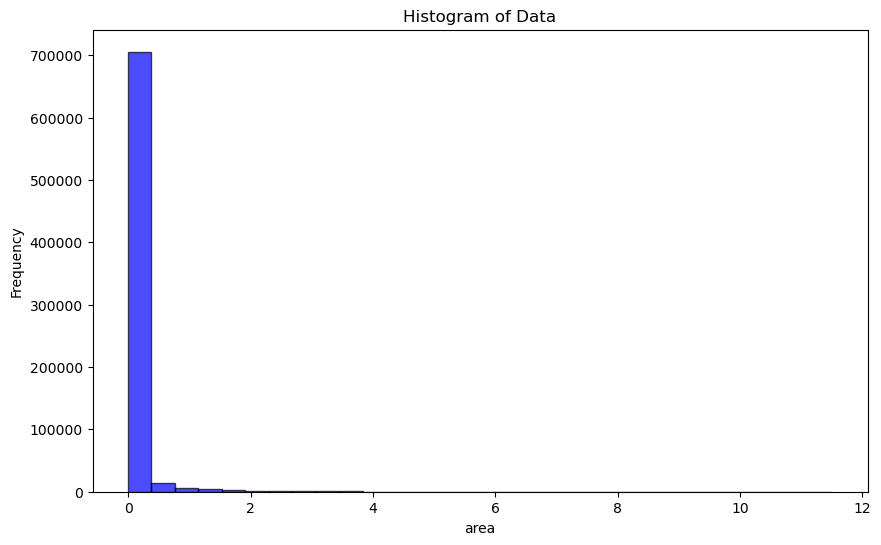

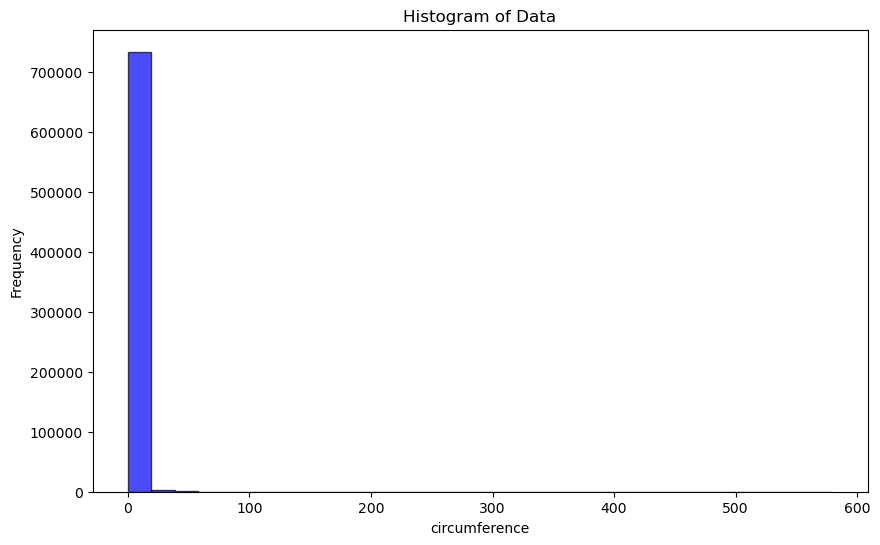

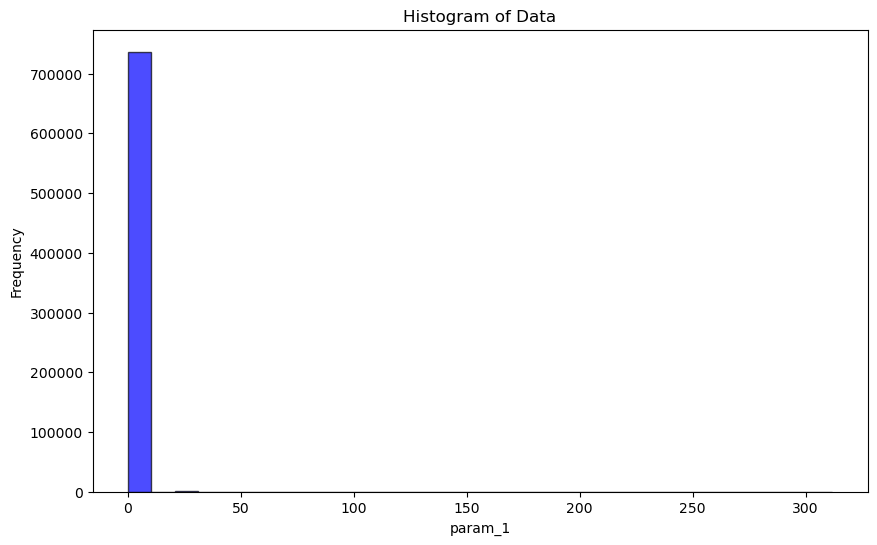

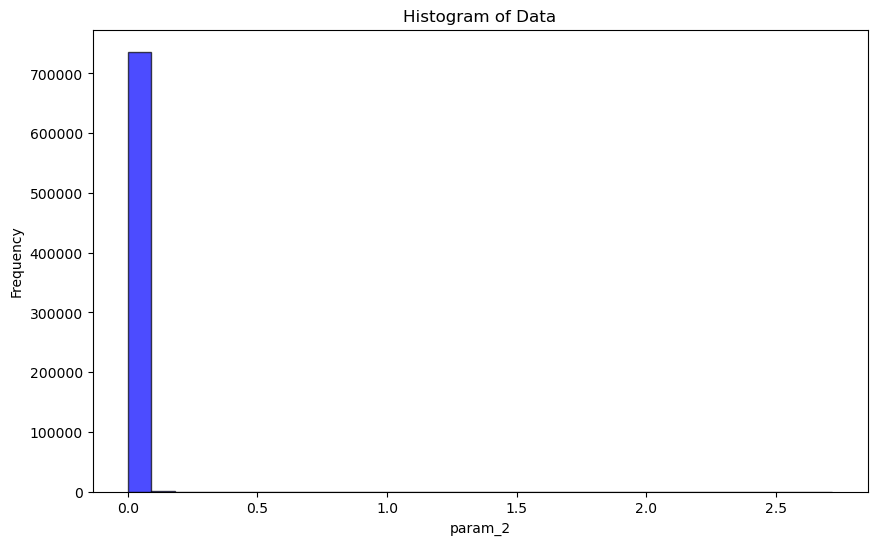

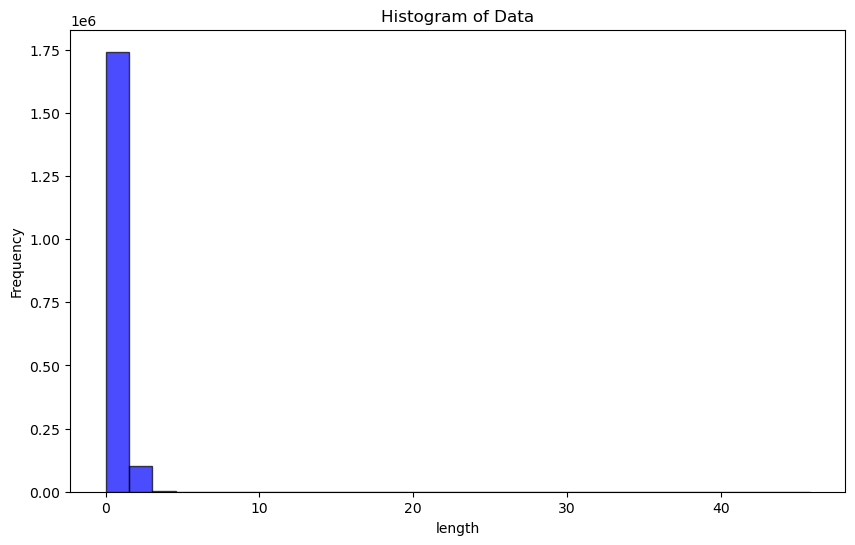

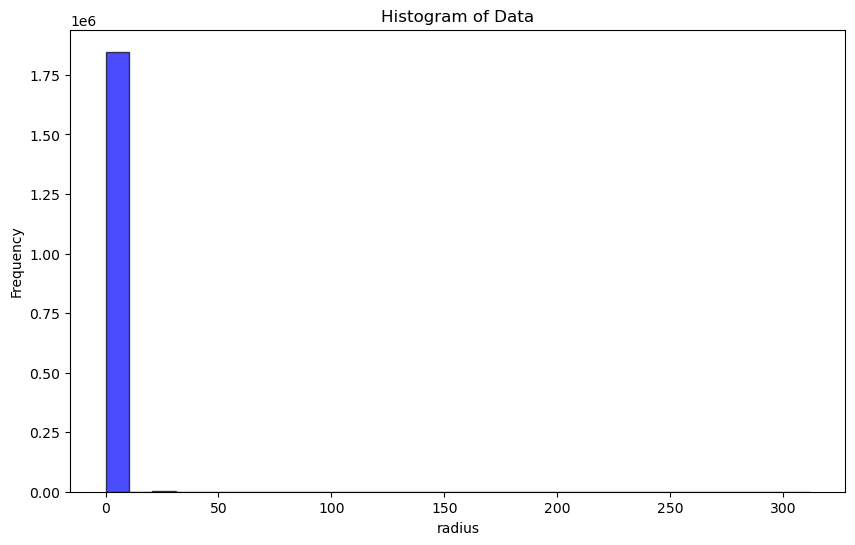

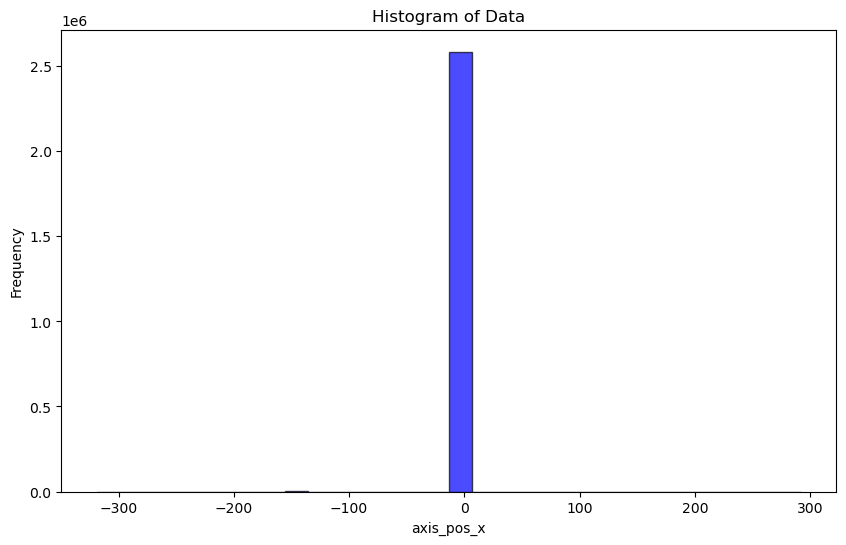

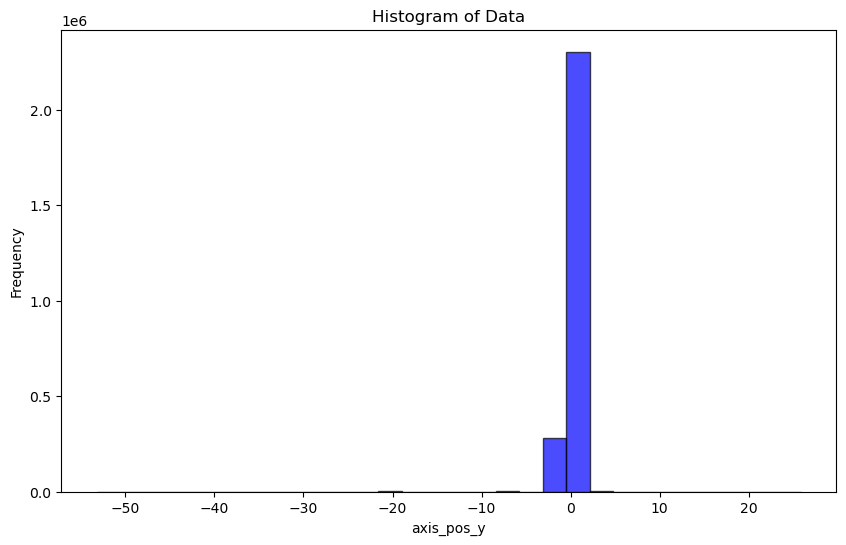

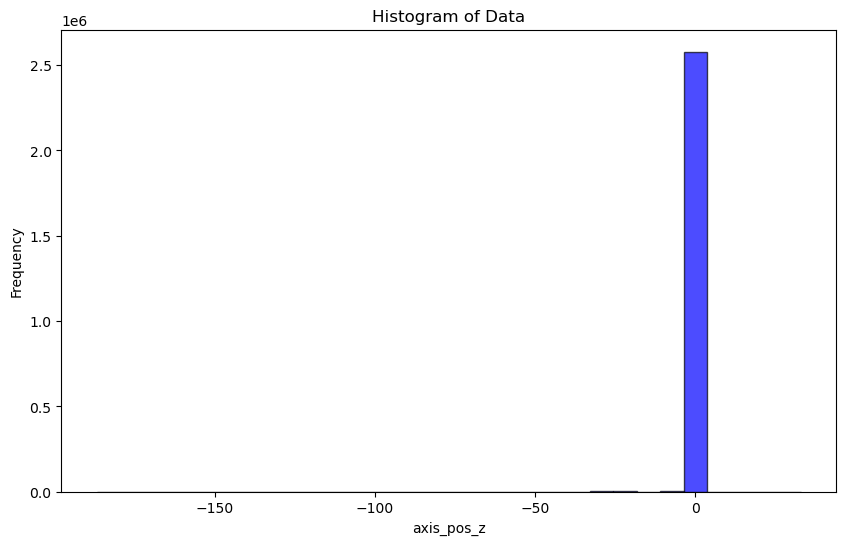

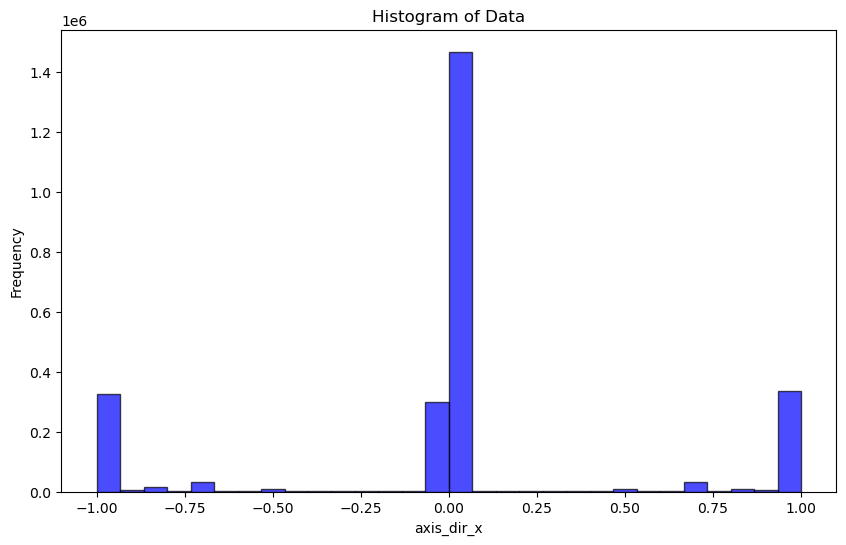

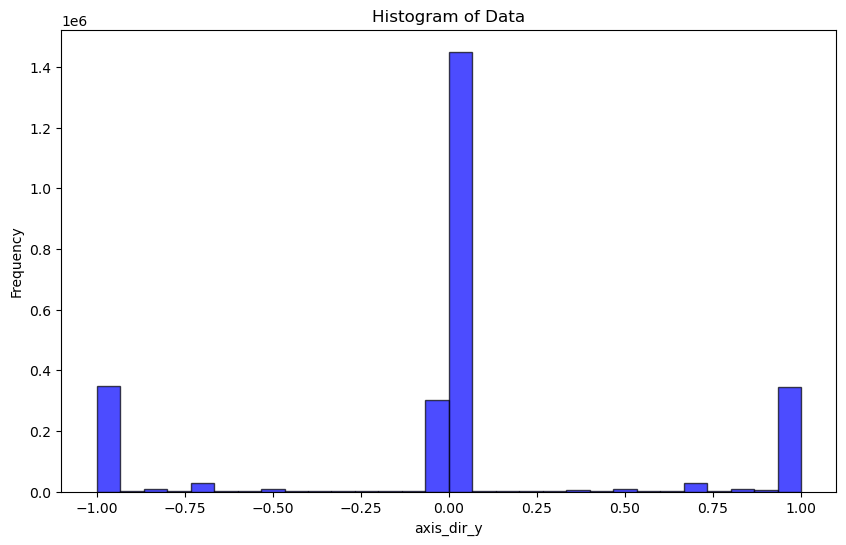

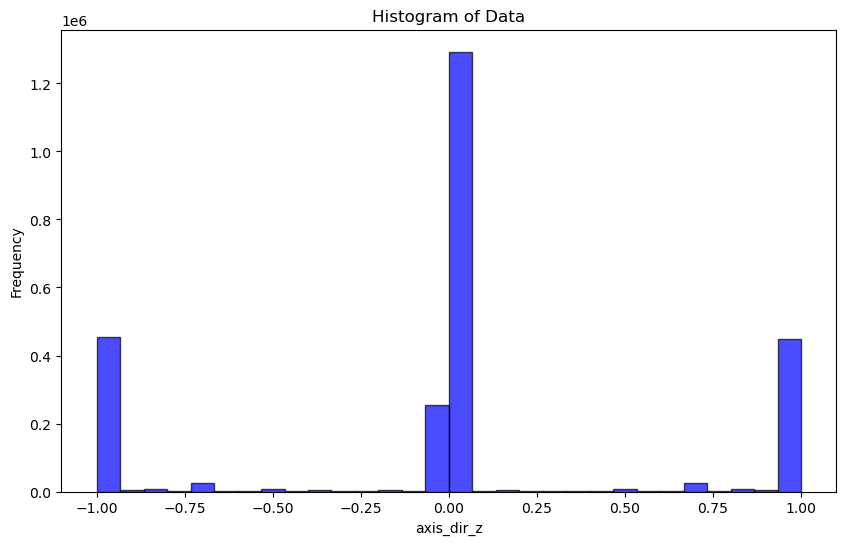

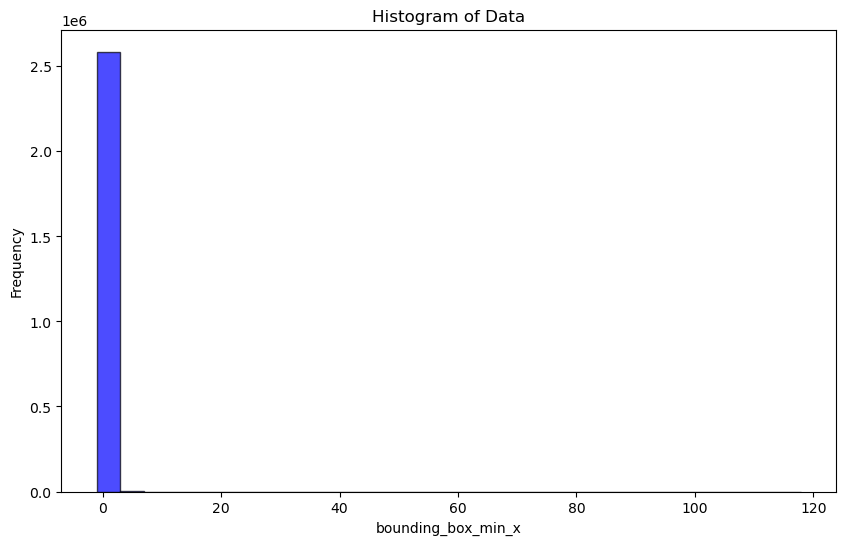

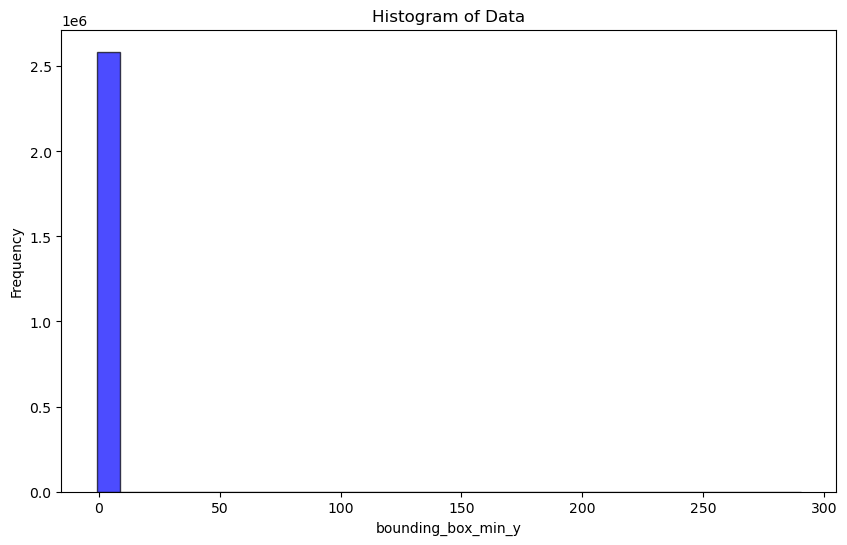

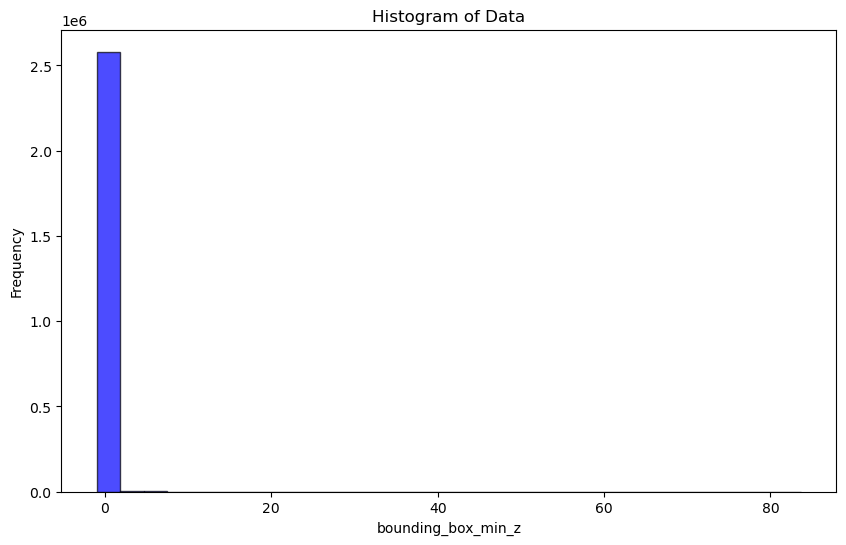

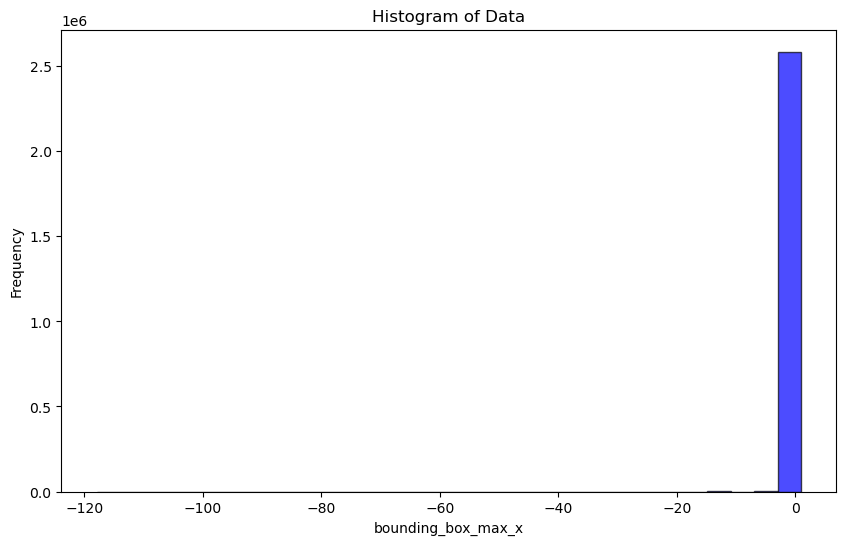

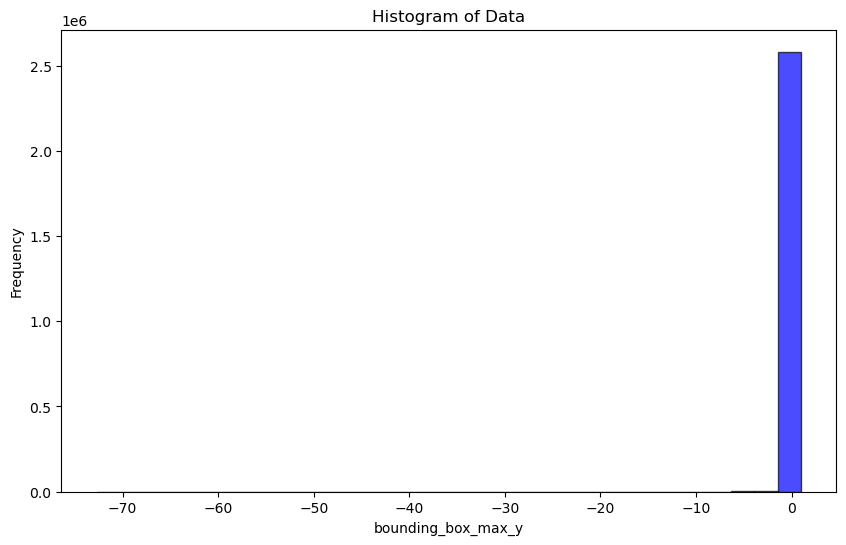

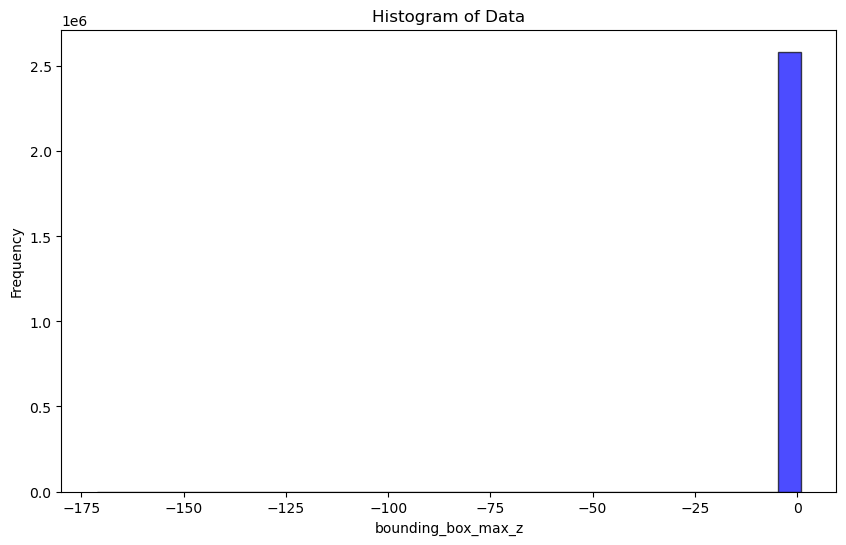

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

for key, value in feature_to_values.items():
    plt.figure(figsize=(10, 6))
    plt.hist(value, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Histogram of Data')
    plt.xlabel(key)
    plt.ylabel('Frequency')
    plt.show()

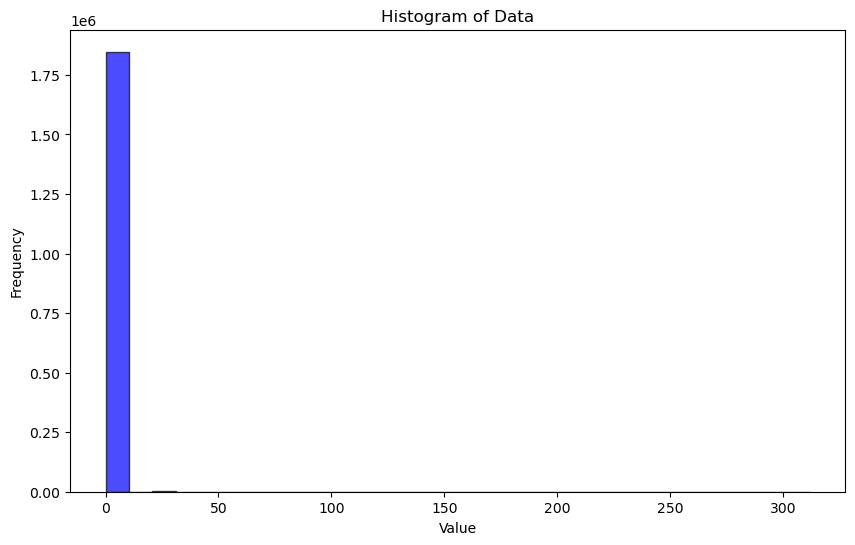

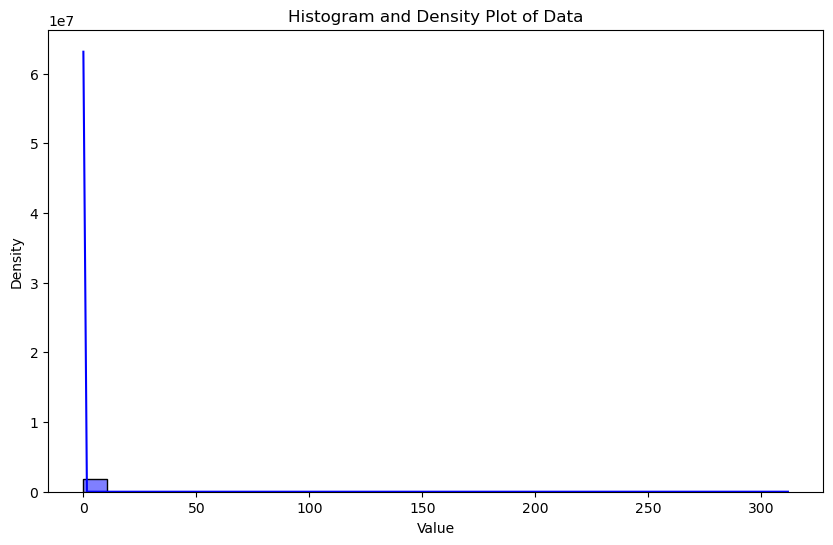

/tmp/ipykernel_1461227/1233898139.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['value'], shade=True, color='blue')


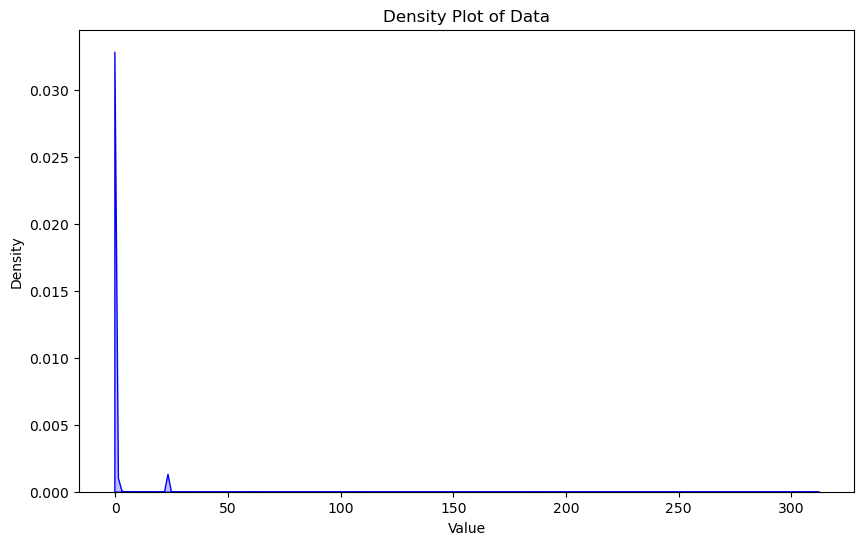

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# # 生成示例数据
# np.random.seed(0)
# data = np.random.randn(1000)  # 生成1000个服从正态分布的随机数

# 使用Pandas DataFrame存储数据
df = pd.DataFrame(feature_to_values['radius'], columns=['value'])

# 使用Matplotlib绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(df['value'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 使用Seaborn绘制直方图和密度图
plt.figure(figsize=(10, 6))
sns.histplot(df['value'], bins=30, kde=True, color='blue')
plt.title('Histogram and Density Plot of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# 使用Seaborn绘制密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(df['value'], shade=True, color='blue')
plt.title('Density Plot of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


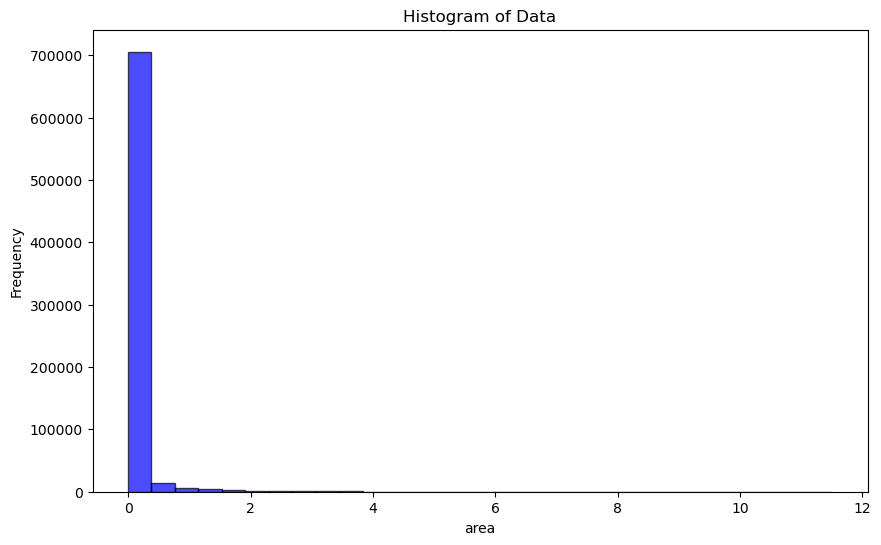

area 11.509769439697266


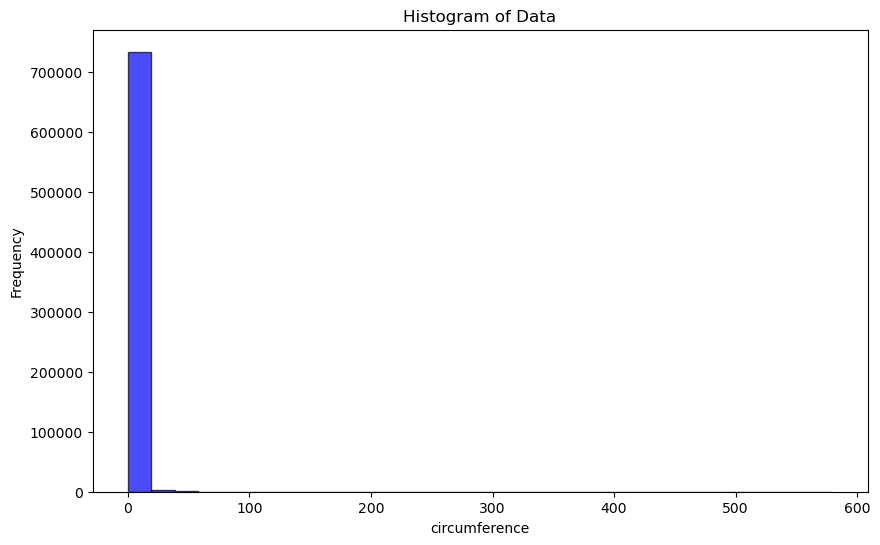

circumference 579.4610595703125


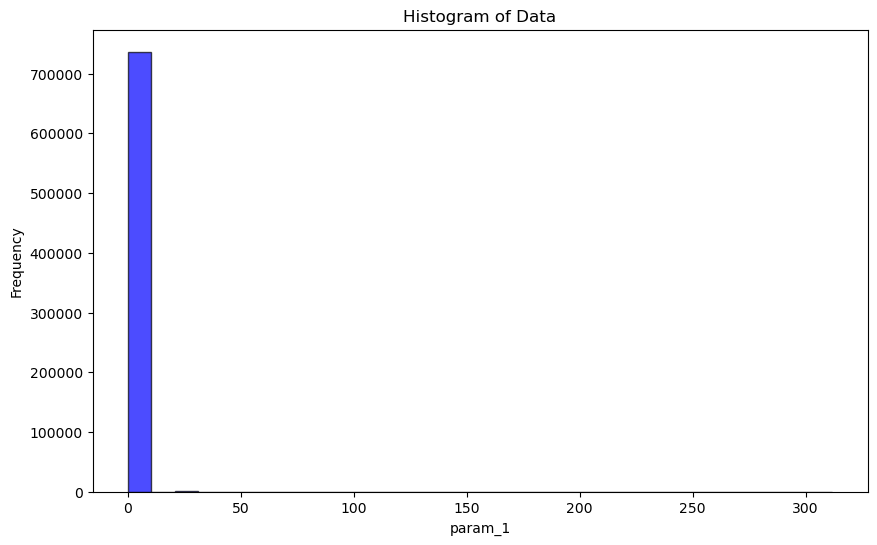

param_1 311.83599853515625


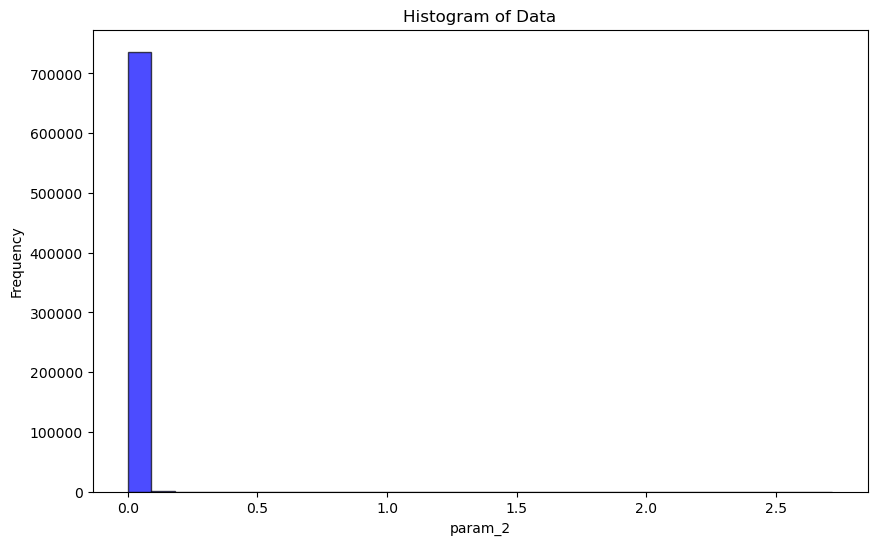

param_2 2.716468572616577


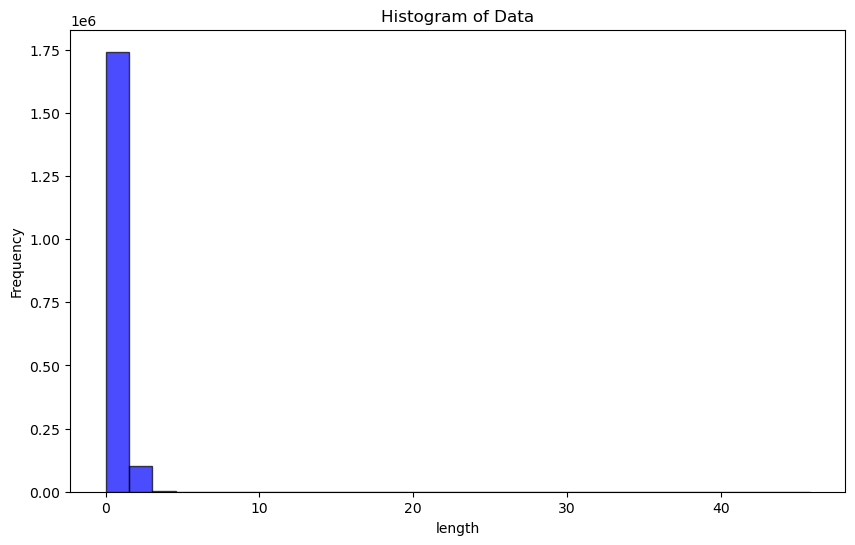

length 45.80609893798828


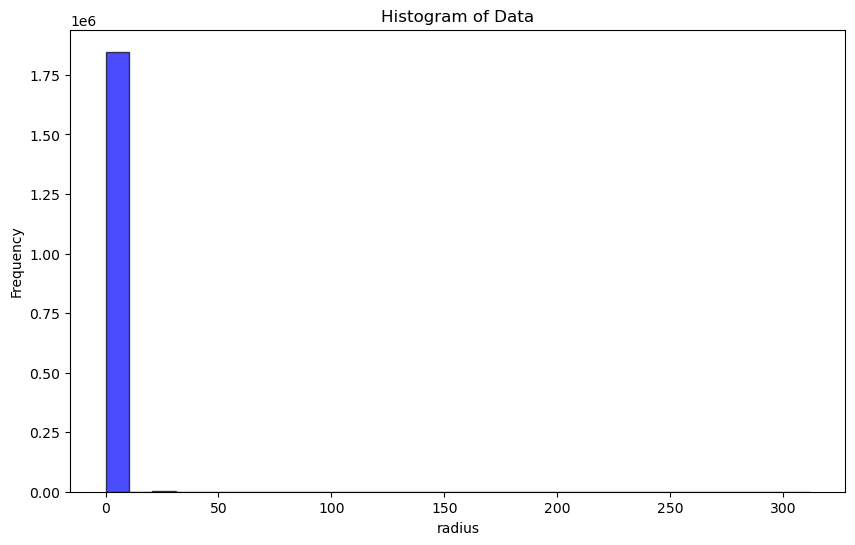

radius 311.83599853515625


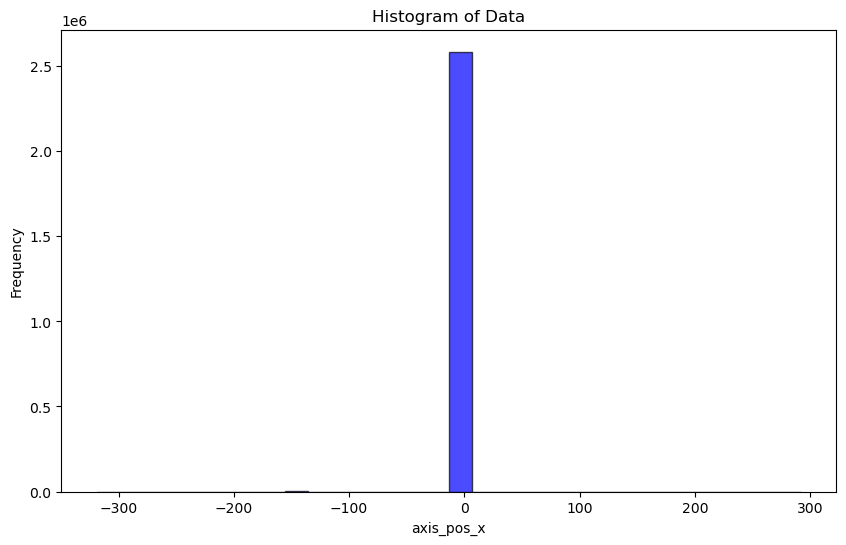

axis_pos_x 292.1576843261719


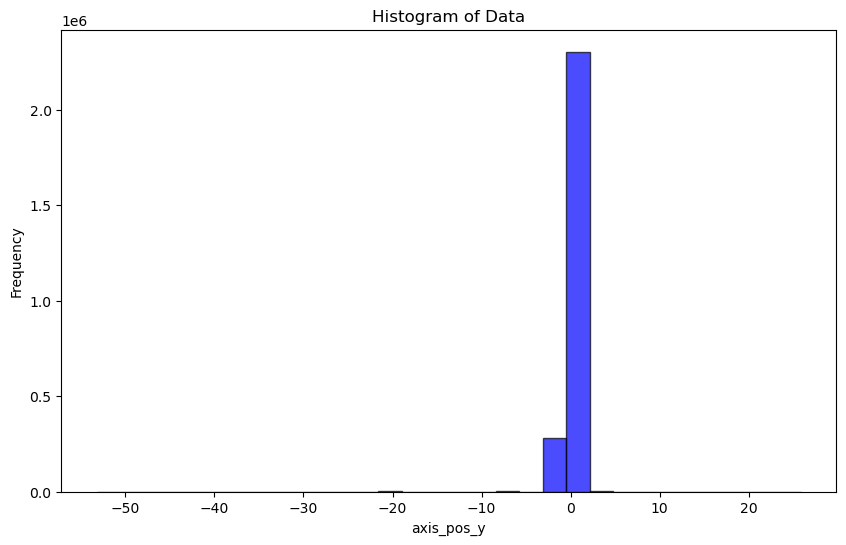

axis_pos_y 25.893701553344727


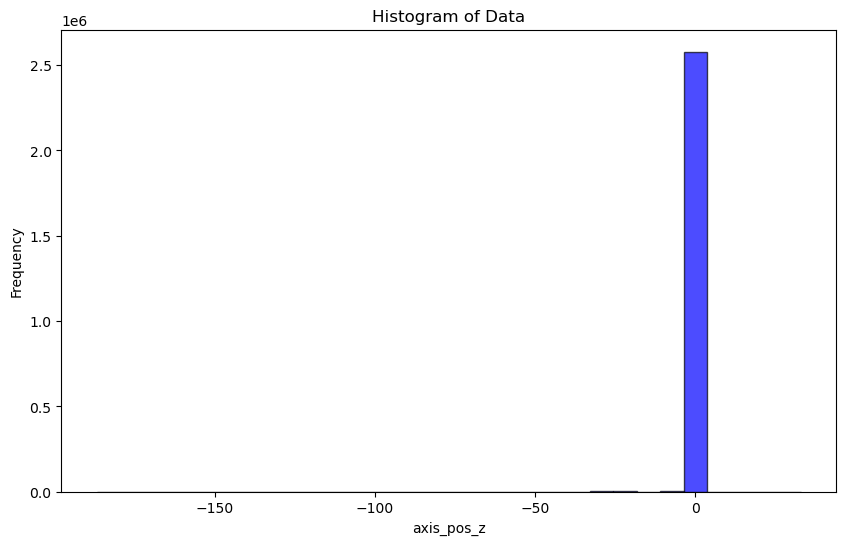

axis_pos_z 33.102779388427734


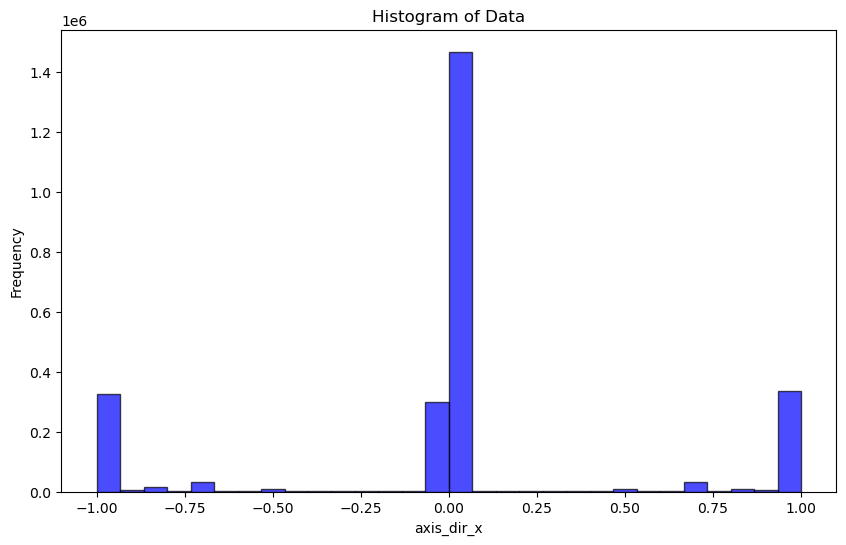

axis_dir_x 1.0


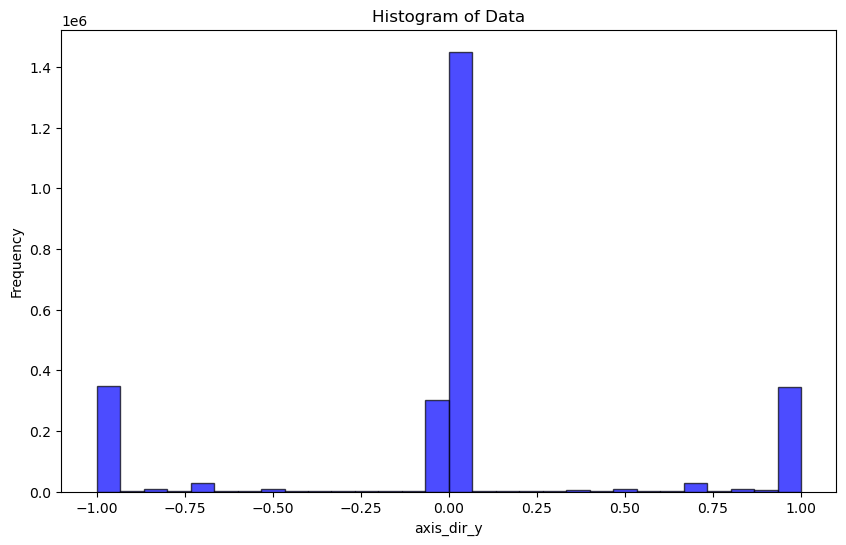

axis_dir_y 1.0


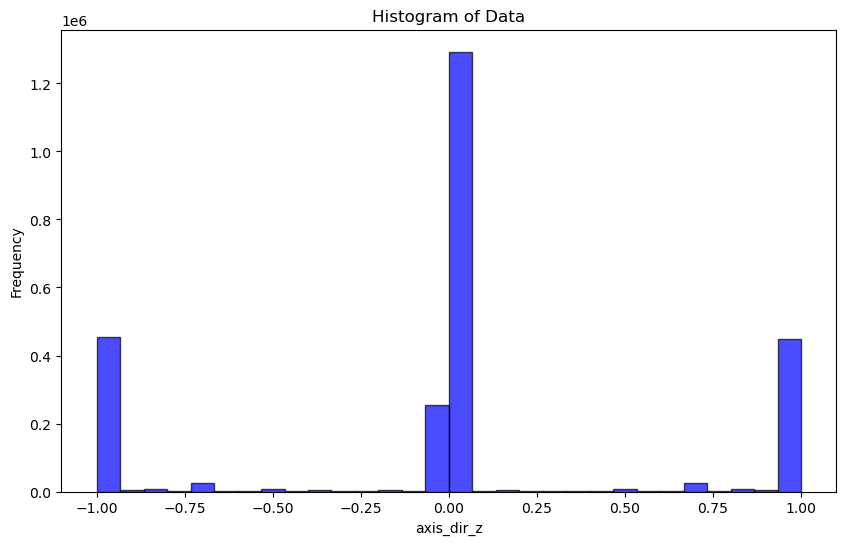

axis_dir_z 1.0


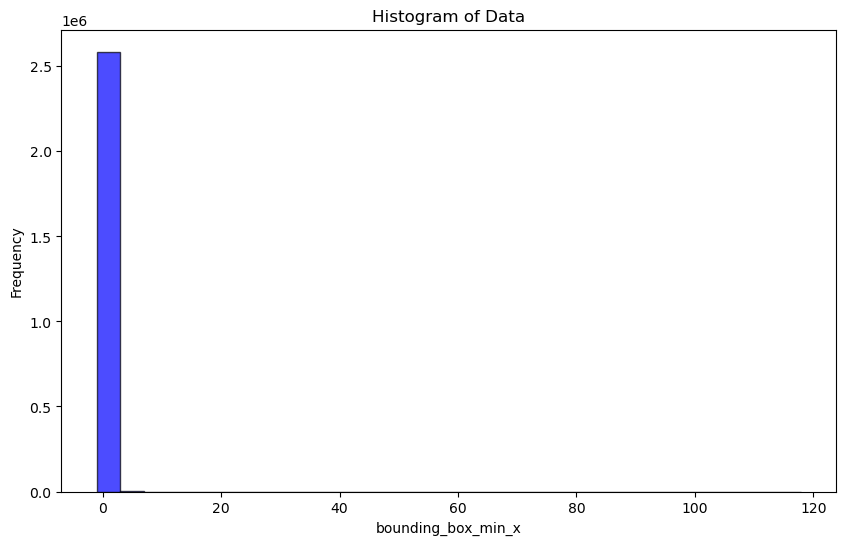

bounding_box_min_x 117.92984771728516


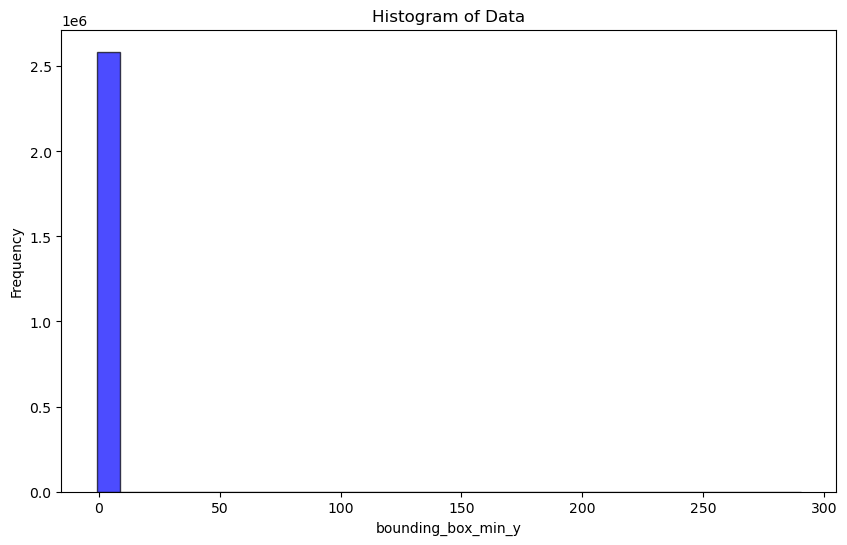

bounding_box_min_y 290.6419982910156


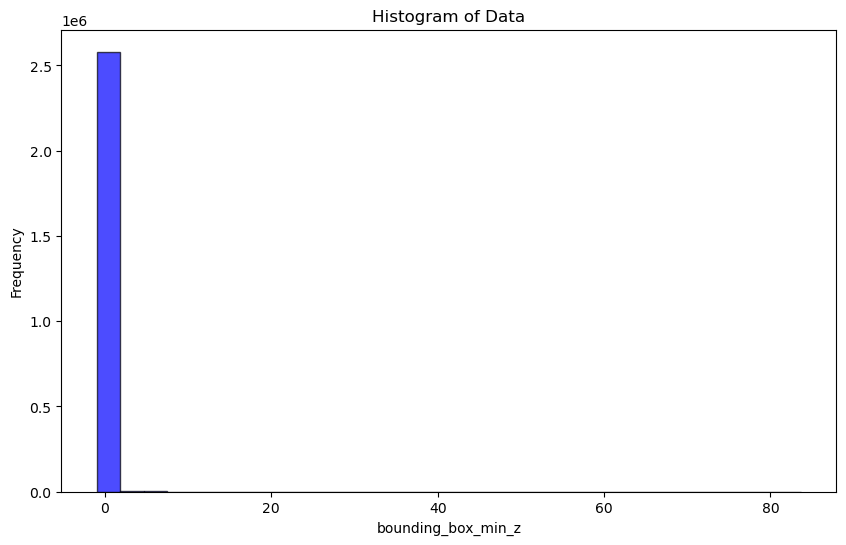

bounding_box_min_z 83.69090270996094


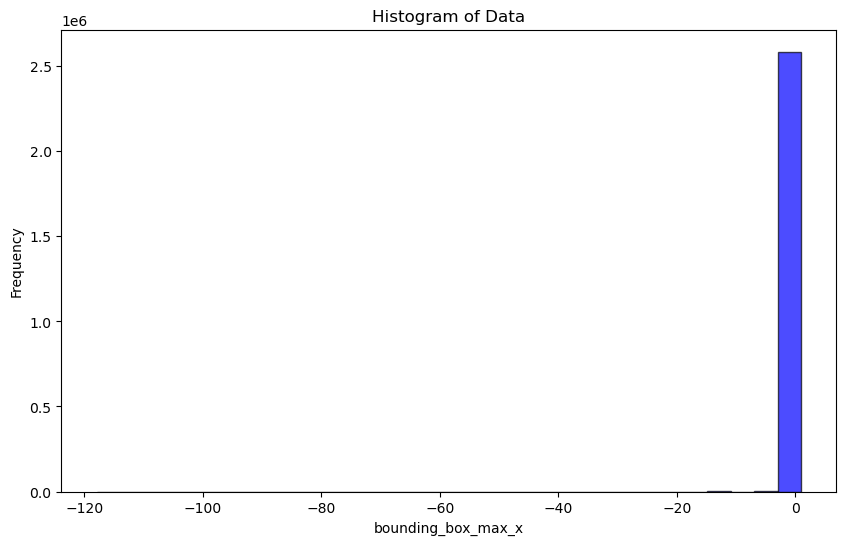

bounding_box_max_x 1.0000007152557373


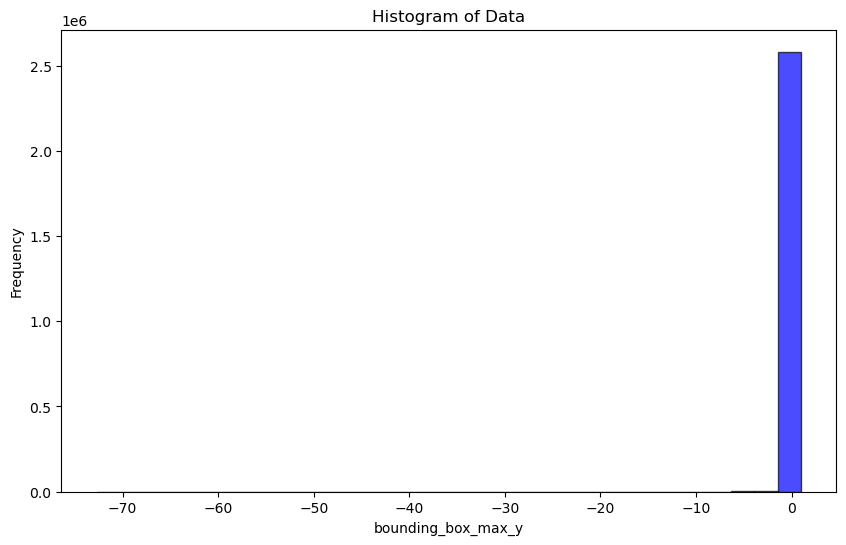

bounding_box_max_y 1.0000004768371582


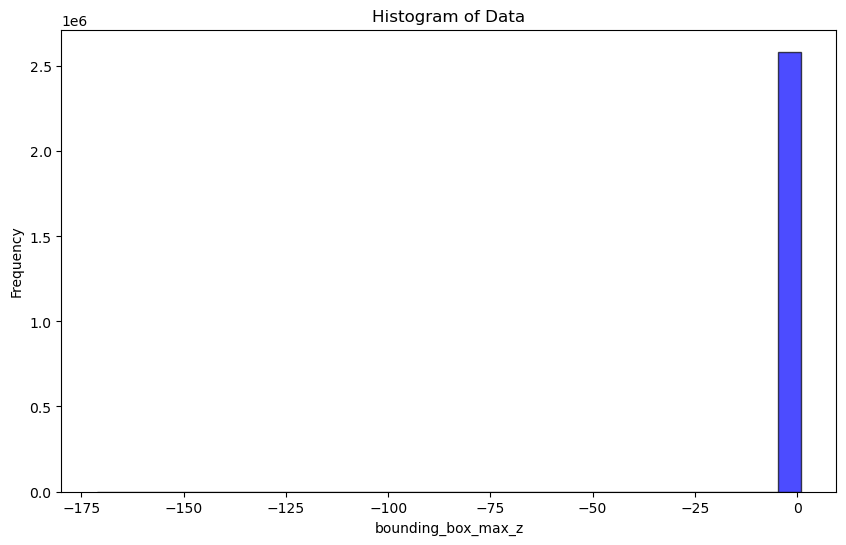

bounding_box_max_z 1.0000003576278687


In [6]:
for key, value in feature_to_values.items():
    plt.figure(figsize=(10, 6))
    plt.hist(value, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Histogram of Data')
    plt.xlabel(key)
    plt.ylabel('Frequency')
    plt.show()
    print(key, value.max())

In [23]:
face_features = [
    "param_1",
    "param_2",
]

edge_features = [
    "radius"
]

vector_features = [
    "axis_pos",
    "axis_dir"
]

for g1, g2, jg in dataset:
    g1_face_indices = torch.where(g1["is_face"] > 0.5)[0].long()
    g2_face_indices = torch.where(g2["is_face"] > 0.5)[0].long()
    g1_edge_indices = torch.where(g1["is_face"] < 0.5)[0].long()
    g2_edge_indices = torch.where(g2["is_face"] < 0.5)[0].long()
    flag = False
    # for feature in face_features:
    #     if g1[feature][g1_face_indices].numpy().max() > 2 or g2[feature][g2_face_indices].numpy().max() > 2:
    #         print(jg.joint_file_name, feature)
    #         flag = True
    #         break
    # if flag:
    #     continue

    # for feature in edge_features:
    #     if g1[feature][g1_edge_indices].numpy().max() > 2 or g2[feature][g2_edge_indices].numpy().max() > 2:
    #         print(jg.joint_file_name, feature)
    #         flag = True
    #         break
    # if flag:
    #     continue
    
    # for feature in vector_features:
    #     if g1[feature].numpy().max() > 2 or g2[feature].numpy().max() > 2:
    #         print(jg.joint_file_name, feature)
    #         flag = True
    #         break
    # if flag:
    #     continue

    if g1["bounding_box"][:,0].numpy().max() > 117:
        print(jg.joint_file_name, "g1")
    if g2["bounding_box"][:,0].numpy().max() > 117:
        print(jg.joint_file_name, "g2")

joint_set_11802.json g1
